## *Stakeholders*

The primary stakeholders are the Seattle Police Department (SPD), the Seattle Office of Police Accountability (OPA), and the Seattle Community Police Commission — bodies responsible for oversight, policy reform, and building public trust in policing. Secondary stakeholders include city council members, civil rights organizations (e.g., ACLU Washington), and community advocacy groups focused on racial equity.

# *BUSINESS PROBLEM*


Assess and mitigate racial disparities in Terry stops to ensure equitable policing practices, maintain public trust, and reduce legal risks associated with biased enforcement.
Terry stops (investigative detentions based on reasonable suspicion) are a key tool for proactive policing, but national and local scrutiny has highlighted potential racial biases in their application. The SPD has faced ongoing federal oversight and public criticism related to use of force and stops. Using this dataset (65,980 Terry stops from 2015 to early 2026), the problem focuses on quantifying disparities in stop rates, frisk rates, and outcomes by perceived race, while evaluating effectiveness (e.g., weapon recovery during frisks).

## *BUSINESS UNDERSTANDING*

This project is designed to analyze and predict the outcomes of Terry Stops conducted by the Seattle Police Department, with a particular emphasis on determining whether a stop culminates in a formal arrest. Using variables such as time of day, precinct location, subject demographics, and the presence of weapons, the model aims to identify the primary factors influencing police decision-making during traffic stops. The findings are intended to support law enforcement agencies by revealing operational trends and informing resource deployment, while also providing policymakers and other stakeholders with a data-driven perspective to assess the consistency, transparency, and underlying determinants of police actions.

# *Data Understanding*

The [Dataset](Terry_Stops_20260103.csv) contains records of 65,980 Terry stops conducted by the Seattle Police Department. Each record includes details such as subject demographics, officer information, stop resolution, weapon involvement, and location. Below is a breakdown of key distributions and statistics derived from the data.

**Key Features:**
The variables in this dataset can be grouped into four primary categories:

* **Subject Demographics:** Characteristics describing the individual(s) stopped by an officer, including but not limited to `Subject Age Group`, `Subject Perceived Race`, and `Subject Perceived Gender`.

* **Officer Demographics:** Attributes related to the officer involved in the stop, such as `Officer ID`, `Officer Gender`, `Officer Race`, and `Officer Year of Birth`.

* **Event Details:** Contextual information surrounding the stop, including `Reported Date`, `Occurred Date`, `Precinct`, `Sector`, and `Beat`.

* **Operational Factors:** Procedural elements of the stop, including `Initial Call Type`, `Final Call Type`, `Frisk Flag`, and `Weapon Type`.

<br>

The target variable for this study is `Arrest Flag`, a binary indicator denoting whether a stop resulted in a physical arrest (Y) or did not (N). This variable is central to the classification task being addressed.

<br>

The dataset exhibits a pronounced class imbalance, characterized by:

* No Arrest (N): approximately 89% of observations (58,723 stops)
* Arrest (Y): approximately 11% of observations (7,257 stops)

As a result, the modeling approach must explicitly address this imbalance to avoid bias toward predicting “No Arrest” and achieving misleadingly high accuracy.

<br>

Regarding data quality, several key issues were identified:

1. **Missing Data:** The `Weapon Type` field contains a substantial number of missing entries, which may suggest that no weapon was present during many stops.

2. **Placeholder Entries:** Multiple variables include placeholder values such as `-` or `Unknown`, necessitating cleaning during preprocessing.

3. **High-Cardinality Categorical Variables:** Fields like `Call Type` and `Final Call Type` contain numerous unique text values, requiring consolidation or dimensionality reduction to support effective modeling.

4. **Subject Identification Limitations:** Many records list a `Subject ID` of -1, indicating that a large portion of subjects were not uniquely identified or linked to a centralized identification system.


# Importation of all necessary libraries 
This is to ensure efficient data processing.

In [83]:
#Importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [84]:
# Loading the dataset
data = pd.read_csv('Terry_Stops_20260103.csv')
data.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Occurred Date
0,56 and Above,-1,20190000057245,532414,Arrest,NaN,8606,1965,Female,White,...,ASLT - WITH OR W/O WPNS (NO SHOOTINGS),"ASSAULTS, OTHER",911,TRAINING - FIELD TRAINING SQUAD,N,N,West,M,M3,2019-02-15T13:15:00
1,46 - 55,7729078044,20230000235837,51923259552,Field Contact,-,4494,1961,Male,White,...,DISTURBANCE,MISCHIEF OR NUISANCE - GENERAL,911,CRG - SQUAD 81D,N,Y,Southwest,W,W1,2023-08-16T20:31:00
2,26 - 35,-1,20180000002293,434590,Field Contact,NaN,8022,1990,Male,Hispanic,...,-,-,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,2018-06-24T18:49:00
3,-,31629429379,20220000039527,31629401025,Field Contact,Knife/Cutting/Stabbing Instrument,6885,1976,Male,Asian,...,DISTURBANCE,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 2ND W - SPECIAL BEATS,N,Y,West,M,M2,2022-02-15T17:42:00
4,1 - 17,-1,20170000317010,301638,Arrest,NaN,7773,1978,Male,White,...,OBS - FIGHT - IP - PHYSICAL (NO WEAPONS),"ASSAULTS, OTHER",911,NORTH PCT 3RD W - B/N RELIEF,N,N,North,L,L3,2017-08-27T03:18:00


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65980 entries, 0 to 65979
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         65980 non-null  object
 1   Subject ID                65980 non-null  int64 
 2   GO / SC Num               65980 non-null  int64 
 3   Terry Stop ID             65980 non-null  int64 
 4   Stop Resolution           65980 non-null  object
 5   Weapon Type               33415 non-null  object
 6   Officer ID                65980 non-null  object
 7   Officer YOB               65980 non-null  int64 
 8   Officer Gender            65980 non-null  object
 9   Officer Race              65980 non-null  object
 10  Subject Perceived Race    65980 non-null  object
 11  Subject Perceived Gender  65980 non-null  object
 12  Reported Date             65980 non-null  object
 13  Initial Call Type         65980 non-null  object
 14  Final Call Type       

# *Exploratory Data Analysis*





1. **Data Quality Check**

The [Dataset][def]contains a total of 65,980 stops records and 23 columns with no duplicate entries within the entire dataset.

However, there were some significant instances of missing data such as:
 
  * Weapon type likely indicating there might have been 'No weapons' or they were 'Not recorded'.

  * Officer Squad where a small number; 566 of them are missing.

The 'Arrest Flag' variable shows significant class imbalance, where 88.5% of cases are non-arrests and 11.5% are arrests.

[def]: Terry_Stops_20260103.csv

2. **Univariate Analysis**

Subject Demographics:

Age: The most frequently stopped age group is 26-35, followed by 36-45 and 18-25.

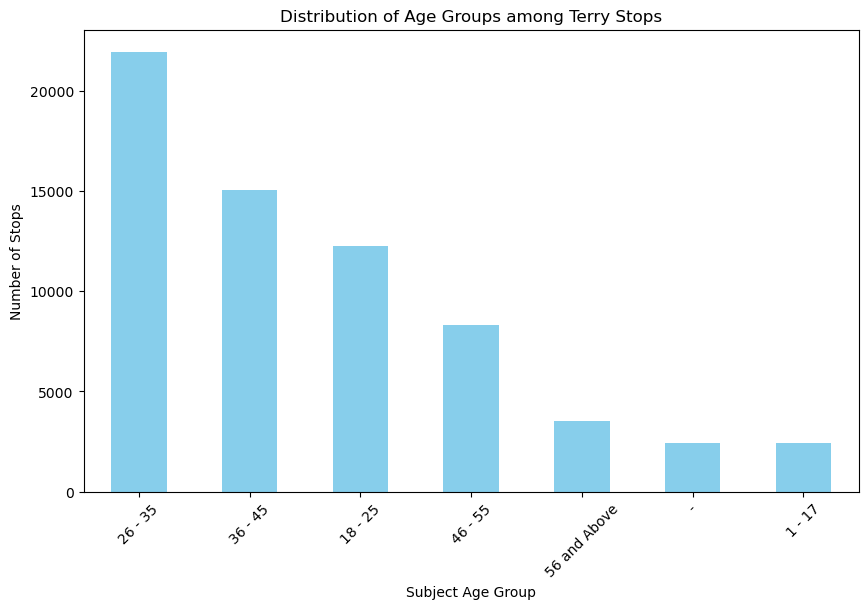

In [86]:
# A bar chart to show the distribution of age groups among the stops
plt.figure(figsize=(10,6))
data['Subject Age Group'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Age Groups among Terry Stops')   
plt.xlabel('Subject Age Group')
plt.ylabel('Number of Stops')
plt.xticks(rotation=45)
plt.show()

Race:There is a significant drop of other racial groups however the White, Black or African American make up the majority of the subjects.

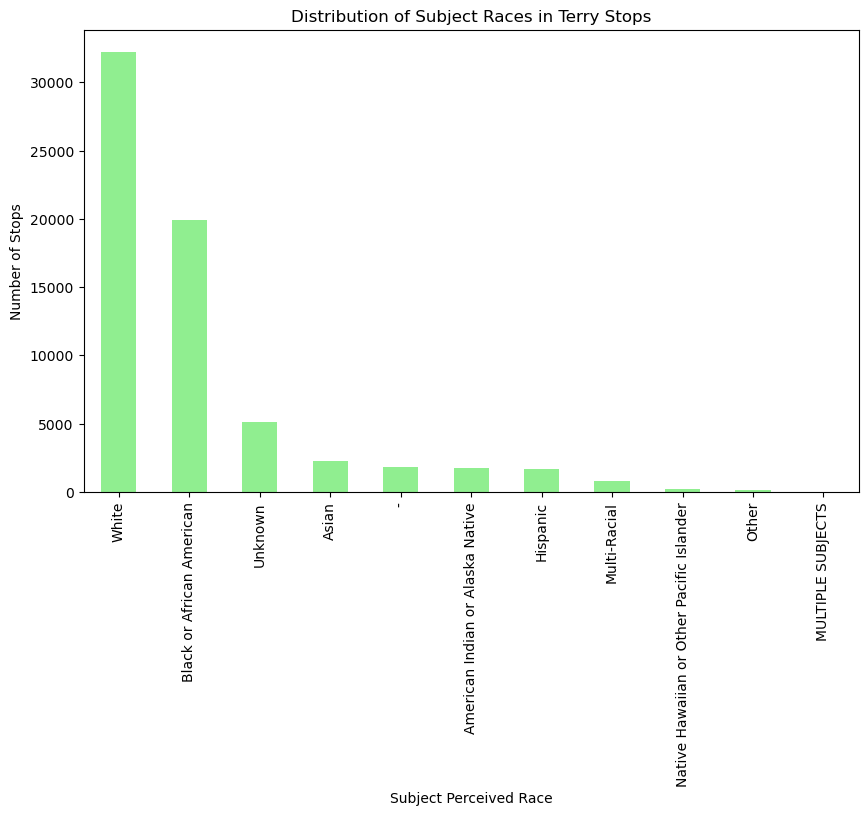

In [87]:
# A bar chart showing the distribution of subject races
plt.figure(figsize=(10,6))
data['Subject Perceived Race'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribution of Subject Races in Terry Stops')
plt.xlabel('Subject Perceived Race')
plt.ylabel('Number of Stops')
plt.xticks(rotation=90)
plt.show()

Stop Outcomes:

Resolution: Field Contact is the most frequent stop outcome, with Offense Report and Arrest occurring less often, reinforcing that most Terry Stops do not culminate in immediate booking.

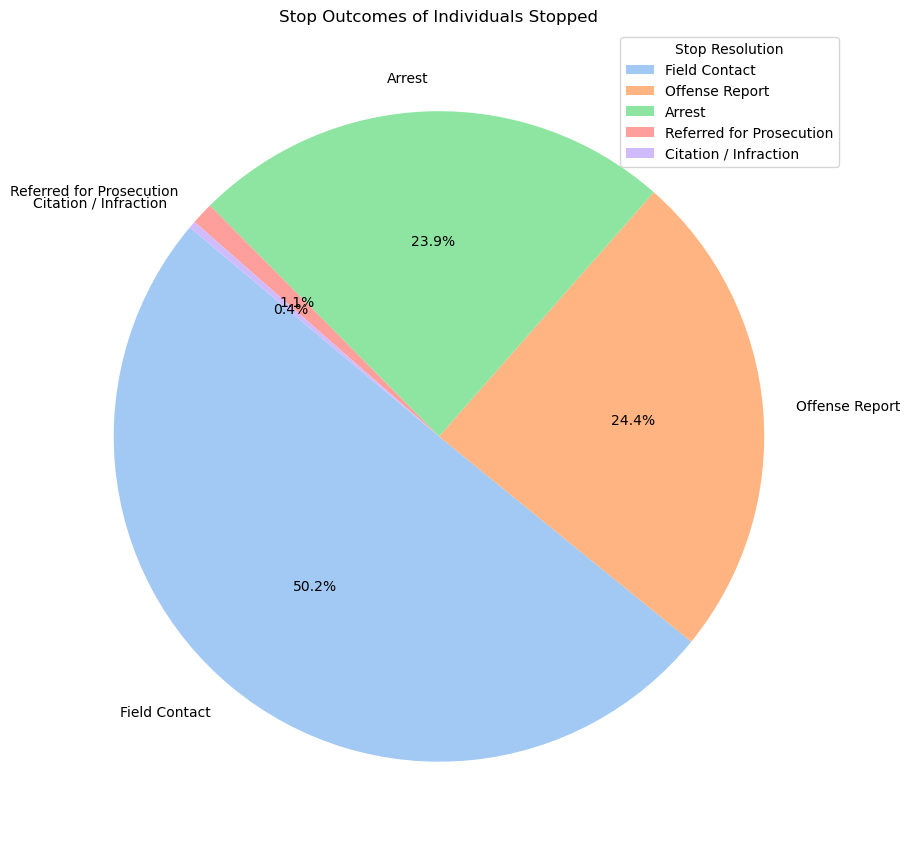

In [88]:
#A pie chart exhibiting the stop outcomes of individuals stopped
plt.figure(figsize=(10.56,10.56))
data['Stop Resolution'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Stop Outcomes of Individuals Stopped')
plt.legend(title='Stop Resolution', loc='upper right')
plt.ylabel('')
plt.show()

3. **Key Relationships (Bivarate Analysis)**

Arrest rates by Race:

By displaying arrest proportions by race, this chart helps identify whether arrest outcomes differ across racial groups once a stop is initiated.

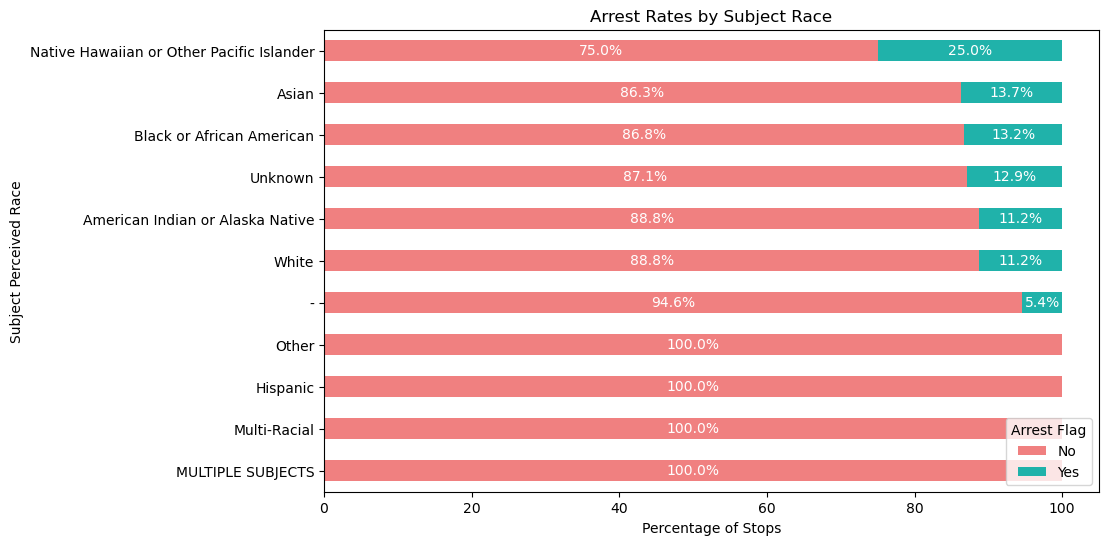

In [89]:
# A bar chart showing the Arrest rates by Race
race_arrest = pd.crosstab(data['Subject Perceived Race'], data['Arrest Flag'], normalize='index') * 100

#Sorting the values for better visualization
if 'Y' in race_arrest.columns:
    race_arrest = race_arrest.sort_values(by='Y', ascending=True)

plot = race_arrest.plot(kind='barh', stacked=True, figsize=(10,6), color=['lightcoral', 'lightseagreen'])
plt.title('Arrest Rates by Subject Race')
plt.xlabel('Percentage of Stops')
plt.ylabel('Subject Perceived Race')
plt.legend(title='Arrest Flag', labels=['No', 'Yes'], loc='lower right')


#Adding percentage labels to each bar segment
for i in plot.patches:
    if isinstance(i, Rectangle):
      width = i.get_width()
    if width > 0: # type: ignore
        plt.text(i.get_x() + width / 2, i.get_y() + i.get_height() / 2, # type: ignore
                 f'{width:.1f}%', ha='center', va='center', color='white', fontsize=10)  # type: ignore
plt.show()    

## **Data Preparation**

### 1. Missing Values

In [90]:
#Checking for missing values in the dataset 
data.isnull().sum()

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 566
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
Occurred Date                   0
dtype: int64

With the `Weapon Type` and ` Officer Squad` having missing values, it will be necessary to replace them with 'None' and 'Unknown' rather than dropping them which might lead to loss of actual arrest cases.

In [91]:
# Weapon Type Missing Values replaced with 'None'
data['Weapon Type'] = data['Weapon Type'].fillna('None')
data['Weapon Present'] = data['Weapon Type'].apply(lambda x: 'No' if x == 'None' else 'Yes')


# Officer Squad Missing Values replaced with 'Unknown'
data['Officer Squad'] = data['Officer Squad'].fillna('Unknown')

### 2. **Handling the many different Placeholders**

The `Weapon Type` column has various placeholders representing the weapon type present. The placehoolders inclide: `Nan`,`-` and `None` which actively mean the same thing which is, there was no weapon.

In [92]:
# Replacing NaNs and messy placeholder symbols with 'None'   
data['Weapon Type'] = data['Weapon Type'].replace(['-','None/Not Applicable'], 'None')

The `Subject Age Group` also has dashes that have to be replaced with 'unknown' representing age groups that are not known.

In [93]:
data['Subject Age Group'] = data['Subject Age Group'].replace(['-','Unknown'], 'Unknown')

The `Subject Perceived Race` feature contains both 'Unknown' and '-' values, which represent the same category and should be consolidated into a single standardized label. 

Additionally, there is a single 'Multiple Subjects' entry that can be recoded as multi-racial for analytical consistency, as it represents an outlier.

In [94]:
data['Subject Perceived Race'] = data['Subject Perceived Race'].replace(['-','Unknown'], 'Unknown') 

#Replacing outliers with Multi-Racial in Subject Perceived
data['Subject Perceived Race'] = data['Subject Perceived Race'].replace(['Multi-Racial'], 'Multi-Racial')

The `Subject Perceived Gender` feature contains entries such as 'Unable to Determine', '-', and 'Unknown', which can be consolidated into a single 'Unknown' category. Additionally, the `Subject ID` field includes an invalid value (-1) that should be recoded as 'Unknown'.

In [95]:
data['Subject Perceived Gender'] = data['Subject Perceived Gender'].replace('-', 'Unknown')
data['Subject Perceived Gender'] = data['Subject Perceived Gender'].replace('Unable to Determine', 'Unknown')
data['Subject Perceived Gender'] = data['Subject Perceived Gender'].replace('MULTIPLE SUBJECTS', 'Unknown')

# Standardizing the 'Subject ID' column by replacing messy placeholder symbols with 'Unknown'
data['Subject ID'] = data['Subject ID'].replace(-1, 'Unknown')

The `Precinct` column contains placeholder values such as '-', 'Unknown', 'OOJ' (Out of Jurisdiction), and 'FK ERROR', which should be consolidated into a single 'Unknown' category.
 The `Sector` column also includes '-' values that should be recoded as 'Unknown', as valid sectors consist only of single-letter codes. Similarly, the `Beat` column contains inconsistent placeholders; valid beat values should follow a two-character alphanumeric format.

In [96]:
data['Precinct'].value_counts()
data['Precinct'] = data['Precinct'].replace(['-', 'OOJ', 'FK ERROR'], 'Unknown')

# Standardizing the 'Sector' column by replacing messy placeholder symbols with 'Unknown'
data['Sector'] = data['Sector'].replace(['-', '99', 'OOJ'], 'Unknown')

# Standardizing the 'Beat' column by replacing messy placeholder symbols with 'Unknown'
data['Beat'] = data['Beat'].replace(['-', '99', 'OOJ', 'S'], 'Unknown')

# Standardizing the 'Initial Call Type' column by replacing messy placeholder symbols with 'Unspecified'
data['Initial Call Type'] = data['Initial Call Type'].replace('-', 'Unspecified')

# Standardizing the 'Final Call Type' column by replacing '-' with 'Unspecified'
data['Final Call Type'] = data['Final Call Type'].replace('-', 'Unspecified')

# Standardizing the 'Frisk Flag' column by replacing '-' symbol with 'Unspecified'
data['Frisk Flag'] = data['Frisk Flag'].replace('-', 'Unspecified')

### 3. Handling the varying data types

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65980 entries, 0 to 65979
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         65980 non-null  object
 1   Subject ID                65980 non-null  object
 2   GO / SC Num               65980 non-null  int64 
 3   Terry Stop ID             65980 non-null  int64 
 4   Stop Resolution           65980 non-null  object
 5   Weapon Type               65980 non-null  object
 6   Officer ID                65980 non-null  object
 7   Officer YOB               65980 non-null  int64 
 8   Officer Gender            65980 non-null  object
 9   Officer Race              65980 non-null  object
 10  Subject Perceived Race    65980 non-null  object
 11  Subject Perceived Gender  65980 non-null  object
 12  Reported Date             65980 non-null  object
 13  Initial Call Type         65980 non-null  object
 14  Final Call Type       

The `Reported date` and the `Occurred date` columns need to be converted to date values.

In [98]:
# Converting 'Reported Date' to datetime format
data['Reported Date'] = pd.to_datetime(data['Reported Date'], errors='coerce')

# Converting 'Occurred Date' to datetime format
data['Occurred Date'] = pd.to_datetime(data['Occurred Date'], errors='coerce')

### 4.Feature Engineering

In [99]:
# Create a 'timestamp' column safely. Prefer 'Occurred Date', then 'Reported Date', else create empty column.
if 'timestamp' in data.columns:
	data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
elif 'Occurred Date' in data.columns:
	data['timestamp'] = pd.to_datetime(data['Occurred Date'], errors='coerce')
elif 'Reported Date' in data.columns:
	data['timestamp'] = pd.to_datetime(data['Reported Date'], errors='coerce')
else:
	# No suitable datetime source found; create column with missing datetimes
	data['timestamp'] = pd.NaT

In [100]:
data['Occurred Date']= pd.to_datetime(data['Occurred Date'], errors='coerce')

In [101]:
# Ensure 'Occurred Date' is datetime, then extract Hour, Month, DayOfWeek, and Year using DatetimeIndex
data['Occurred Date'] = pd.to_datetime(data['Occurred Date'], errors='coerce')
dt_index = pd.DatetimeIndex(data['Occurred Date'])

data['Hour'] = dt_index.hour
data['Month'] = dt_index.month
data['DayOfWeek'] = dt_index.dayofweek  # 0=Monday, 6=Sunday
data['Year'] = dt_index.year

In [102]:
#Defining time-of-day intervals to analyze how arrest rates change across different periods of the day
def get_time_of_day(hour: int) -> str:

    if pd.isna(hour):
        return 'Unknown' 
    if 5 <= hour < 12:
        return 'Morning'      # 05:00 – 11:59
    elif 12 <= hour < 17:
        return 'Afternoon'    # 12:00 – 16:59
    elif 17 <= hour < 21:
        return 'Evening'      # 17:00 – 20:59
    else:
        return 'Night'        # 21:00 – 04:59 (High Risks of arrests)

# Apply the function to create the new 'Time_of_Day' column
data['Time_of_Day'] = data['Hour'].apply(get_time_of_day)



In [103]:
# Generating a specific Weekend Flag where; 1=Weekend, 0=Weekday
data['Is_Weekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

To enable the model to capture temporal patterns and recognize that hours 23 and 0 are adjacent, cyclical encoding was applied. This approach mathematically represents time in a circular manner, allowing the model to correctly learn and interpret “late-night” behavioral patterns.

In [104]:
# Mapping hours onto a circle so 23 and 0 are close neighbors.
data['Hour_Sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['Hour_Cos'] = np.cos(2 * np.pi * data['Hour'] / 24)

# Mapping months onto a circle so Dec and Jan are close neighbors.
data['Month_Sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_Cos'] = np.cos(2 * np.pi * data['Month'] / 12)

# Mapping days of the week onto a circle so Sat and Sun are close neighbors.
data['DayOfWeek_Sin'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
data['DayOfWeek_Cos'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)

To estimate the age difference between the officer and the subject, the median value of each age group was used as a substitute for individual ages. As a result, the computed age gaps are approximate rather than exact representations of the true differences.

In [105]:
# Calculating the Officer's age at the time of the stop
data['Officer Age'] = data['Year'] - data['Officer YOB']

                    # Age Difference (Generation Gap)

# Convert Subject Age Range to a single Number (Estimate)
def age_group(age_group):
    if age_group == '1 - 17': return 16
    if age_group == '18 - 25': return 21.5
    if age_group == '26 - 35': return 30.5
    if age_group == '36 - 45': return 40.5
    if age_group == '46 - 55': return 50.5
    if age_group == '56 and Above': return 60 
    return 30.5  # In the case of missing/unknown
data['Subject_Age'] = data['Subject Age Group'].apply(age_group)
data['Age_Difference'] = data['Officer Age'] - data['Subject_Age']

Checking whether the officer and the subject belong to the same ethic background and gender

In [106]:
# Same Race Flag (1 = Match, 0 = Different) to check if the officer and subject share the same racial background
data['Same_Race'] = (data['Officer Race'] == data['Subject Perceived Race']).astype(int)

# Same Gender Flag
data['Same_Gender'] = (data['Officer Gender'] == data['Subject Perceived Gender']).astype(int)

Next I added a `Minority_Interaction` feature to determine whether there exists patterns whereby more arrests were as a result of White officer stopping a non_white Subject.

In [107]:
# Minority Interaction Flag that specifically flags stops where a White Officer stops a Non-White Subject. Thus aiding the  model in bias analysis
data['Subject_Is_White'] = data['Subject Perceived Race'] == 'White'
data['Officer_Is_White'] = data['Officer Race'] == 'White'

data['Minority_Interaction'] = ((data['Officer_Is_White']) & (~data['Subject_Is_White'])).astype(int)

### 5.Feature Selection

In [108]:
# Dropping the unnecessary columns
data = data.drop(columns=['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Stop Resolution', 'Officer YOB', 'Reported Date', 'Final Call Type', 'Officer Squad', 'Officer ID', 'Beat', 'Occurred Date', 'Hour', 'Month', 'DayOfWeek'])
data

,Subject Age Group,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Initial Call Type,Call Type,Arrest Flag,Frisk Flag,...,DayOfWeek_Sin,DayOfWeek_Cos,Officer Age,Subject_Age,Age_Difference,Same_Race,Same_Gender,Subject_Is_White,Officer_Is_White,Minority_Interaction
0,56 and Above,None,Female,White,White,Male,ASLT - WITH OR W/O WPNS (NO SHOOTINGS),911,N,N,...,-0.433884,-0.900969,54,60.0,-6.0,1,0,True,True,0
1,46 - 55,None,Male,White,Asian,Male,DISTURBANCE,911,N,Y,...,0.974928,-0.222521,62,50.5,11.5,0,1,False,True,1
2,26 - 35,None,Male,Hispanic,Hispanic,Male,Unspecified,-,N,N,...,-0.781831,0.623490,28,30.5,-2.5,1,1,False,False,0
3,Unknown,Knife/Cutting/Stabbing Instrument,Male,Asian,White,Female,DISTURBANCE,ONVIEW,N,Y,...,0.781831,0.623490,46,30.5,15.5,0,0,True,False,0
4,1 - 17,None,Male,White,Black or African American,Male,OBS - FIGHT - IP - PHYSICAL (NO WEAPONS),911,N,N,...,-0.781831,0.623490,39,16.0,23.0,0,1,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65975,26 - 35,None,Male,White,White,Male,SHOPLIFT - THEFT,911,N,Y,...,-0.781831,0.623490,52,30.5,21.5,1,1,True,True,0
65976,26 - 35,None,Male,White,White,Male,DISTURBANCE,911,N,N,...,-0.974928,-0.222521,25,30.5,-5.5,1,1,True,True,0
65977,26 - 35,Lethal Cutting Instrument,Male,White,White,Male,DISTURBANCE,911,N,Y,...,-0.433884,-0.900969,36,30.5,5.5,1,1,True,True,0
65978,26 - 35,None,Male,White,Unknown,Male,OBS - FIGHT - IP - PHYSICAL (NO WEAPONS),911,N,Y,...,0.000000,1.000000,50,30.5,19.5,0,1,False,True,1


### 6. Data Preprocessing

For the `Subject Age Group` variable, ordinal encoding was applied to reflect the natural ordering of age categories. Any unknown age group values were replaced with the most frequently occurring age group in the dataset.

In [109]:
# Replacing 'Unknown' in 'Subject Age Group' with the mode '26 - 35'
data['Subject Age Group'].replace({'Unknown': '26 - 35'})

# Now to map the age groups to numerical values for modeling
age_group_mapping = {'1 - 17': 0, 
                     '18 - 25': 1,
                     '26 - 35': 2,
                     '36 - 45': 3,
                     '46 - 55': 4,
                     '56 and Above': 5}

data['Subject Age Group'] = data['Subject Age Group'].map(age_group_mapping)

I then performed One-Hot encoding to the following features:

In [110]:
ohe_columns = ['Officer Gender', 'Officer Race', 'Subject Perceived Race',
               'Subject Perceived Gender', 'Call Type', 'Precinct', 'Time_of_Day']

data1 = pd.get_dummies(data, columns=ohe_columns, drop_first=True)

Since the `Arrest Flag` and `Frisk Flask` are in binary form I decided to use binary encoding

In [111]:
data1['Arrest Flag'] = data1['Arrest Flag'].map({'Y': 1, 'N': 0})
data1['Frisk Flag'] = data1['Frisk Flag'].map({'Y': 1, 'N': 0})

The remaining features: `Initial Call Type`, `Weapon Type` and `Sector` had alot of unique entries which if one-hot-encoded would lead to a lot of dimensions in the dataframe. As a result, I decided to use target encoding to sort this issue out. However, to prevent the risk of data leakage, I had to split the data into training and test data first.

In [112]:
#Setting up the variables
X = data1.drop('Arrest Flag', axis=1)
y = data1['Arrest Flag']

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initializing the Encoder
encoder = TargetEncoder(target_type='binary', smooth='auto', cv=5)

# Applying it to the 3 columns
cols_to_encode = ['Initial Call Type', 'Sector', 'Weapon Type']

# Fitting on training data
X_train[cols_to_encode] = encoder.fit_transform(X_train[cols_to_encode], y_train)

# Transforming test data
X_test[cols_to_encode] = encoder.transform(X_test[cols_to_encode])
X_train.head()

,Subject Age Group,Weapon Type,Initial Call Type,Frisk Flag,Sector,Weapon Present,timestamp,Year,Is_Weekend,Hour_Sin,...,"Call Type_TELEPHONE OTHER, NOT 911",Call Type_TEXT MESSAGE,Precinct_North,Precinct_South,Precinct_Southwest,Precinct_Unknown,Precinct_West,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night
4317,2.0,0.107293,0.019098,0.0,0.148399,No,2018-02-02 15:34:00,2018,0,-0.707107,...,False,False,False,False,True,False,False,False,False,False
21470,0.0,0.107476,0.200076,0.0,0.108875,No,2018-07-21 03:30:00,2018,1,0.707107,...,True,False,False,True,False,False,False,False,False,True
49864,2.0,0.107402,0.211866,1.0,0.210381,Yes,2020-08-30 00:33:00,2020,1,0.000000,...,False,False,False,False,False,False,True,False,False,True
63852,2.0,0.107142,0.018597,0.0,0.182600,No,2019-03-02 04:18:00,2019,1,0.866025,...,False,False,False,False,False,False,True,False,False,True
8457,5.0,0.107293,0.019098,0.0,0.037760,No,2016-04-29 02:28:00,2016,0,0.500000,...,False,False,False,False,False,True,False,False,False,True


Applying standard scaling to prevent any feature from dominating because of its numerical range, thereby improving both model performance and interpretability.


In [113]:
numerical_features = ['Age_Difference', 'Officer Age', 'Subject_Age', 'Year']
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

## **Modelling**

### **1.The Baseline Model**

The [`Terry Stops Dataset`][def] is imbalanced, with the target variable Arrest Flag showing 89% "No Arrest" and 11% "Arrest." If I were lazy and just predicted "No Arrest" for everyone, I’d get 89% accuracy. So, my baseline model is one that always predicts the most frequent class using the “most frequent” strategy.


[def]: Terry_Stops_20260103.csv

In [114]:
# The Dummy Classifier 
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print(classification_report(y_test, y_pred_dummy, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     11682
           1       0.00      0.00      0.00      1514

    accuracy                           0.89     13196
   macro avg       0.44      0.50      0.47     13196
weighted avg       0.78      0.89      0.83     13196



This baseline model doesn’t actually learn anything, as it simply predicts "No Arrest" every time. It ignores all the features and relies solely on the target’s distribution, providing no insight into the factors behind an arrest.

Although the model shows high accuracy, this is misleading due to the class imbalance. Its precision for predicting arrests is 0.00, meaning it never predicts arrests and misses all actual arrests. Therefore, it is not viable for predicting arrests.

### **2. Logistic Regression**

With logistic regression, the model can actively learn the relationships between the features and the target variable, allowing it to make informed predictions based on the data.

In [115]:
# Preprocess: convert non-numeric columns so sklearn can consume them
# Map 'Weapon Present' from 'Yes'/'No' to 1/0 and drop 'timestamp' (we already encoded time info)
for df in (X_train, X_test):
	if 'Weapon Present' in df.columns:
		df['Weapon Present'] = df['Weapon Present'].map({'Yes': 1, 'No': 0})
	if 'timestamp' in df.columns:
		df.drop(columns=['timestamp'], inplace=True)

# Fill remaining numeric NaNs with training medians to avoid NaN errors during fitting
num_medians = X_train.median(numeric_only=True)
X_train.fillna(num_medians, inplace=True)
X_test.fillna(num_medians, inplace=True)

# Initializing the regressor
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Fitting the model
log_reg.fit(X_train, y_train)

# Predicting using the test data
y_pred_lr = log_reg.predict(X_test)
y_pred_proba_lr = log_reg.predict_proba(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred_lr, zero_division=0))
roc_auc = roc_auc_score(y_test, y_pred_proba_lr[:, 1])
print(f'ROC-AUC: {roc_auc:.4f}')

              precision    recall  f1-score   support

           0       0.99      0.66      0.79     11682
           1       0.26      0.93      0.41      1514

    accuracy                           0.69     13196
   macro avg       0.62      0.80      0.60     13196
weighted avg       0.90      0.69      0.75     13196

ROC-AUC: 0.8710


The model can now identify 93% of potential arrests unlike the baseline model which only identified about 0% of the arrests. It also has a better precision that the baseline model of 99% of the time. This model has a lower overall accuracy compared to the baseline model but it is much more useful. 

It is now practically useful to the stakeholders. The ROC-AUC score of 87.1% also validates that the model has a strong predictive power for distuinguishing arrest outcomes hence can effectively rank Terry stops by arrest likelihood

From this model, I was also able to identify the features that mostly lead to a formal arrest:

In [116]:
# Analysing the features
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': log_reg.coef_[0]})
print(coef_df.sort_values(by='Coefficient', ascending=False).head(10))

                                              Feature  Coefficient
5                                      Weapon Present     8.292695
2                                   Initial Call Type     7.479238
1                                         Weapon Type     3.743814
4                                              Sector     2.541140
30                               Officer Race_Unknown     1.421196
0                                   Subject Age Group     0.278998
24                                 Officer Race_Asian     0.214492
26                    Officer Race_Declined to Answer     0.196915
41  Subject Perceived Gender_Gender Diverse (gende...     0.179172
57                                Time_of_Day_Morning     0.141957


`Weapon Present` dominates with the highest coefficient in arrest likelihood, followed by `Initial Call Type` and `Weapon Type` as strong secondary factors. Thus, evidentiary and situational factors far outweigh demographic characteristics in predicting arrest outcomes.
However, this model assumes linear relationships between the features, which may not hold for complex variables. To capture non-linear patterns in high-cardinality features like `Initial Call Type` and `Sector` and their role in arrests, a Random Forest model is a better choice.

### **3.Random Forest**

In [117]:
from sklearn.ensemble import RandomForestClassifier

# Initializing the Model
rf_model = RandomForestClassifier(
      n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1# Using all CPU cores for faster training
)

# Fitting the model
rf_model.fit(X_train, y_train)

# Predicting using the test data
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluating the model
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_rf):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

ROC-AUC Score: 0.8765

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.68      0.81     11682
           1       0.28      0.94      0.43      1514

    accuracy                           0.71     13196
   macro avg       0.63      0.81      0.62     13196
weighted avg       0.91      0.71      0.76     13196



This Random forest model finds 93% of actual arrests and predicts arrest, when it's right 28% of the time. The ROC-AUC of 87.7% also shows excellent discriminative ability. It actually performs slightly better overrally than the Logistic Regressio with an accuracy of 72%.

C:\Users\User\AppData\Local\Temp\ipykernel_17912\2321508450.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


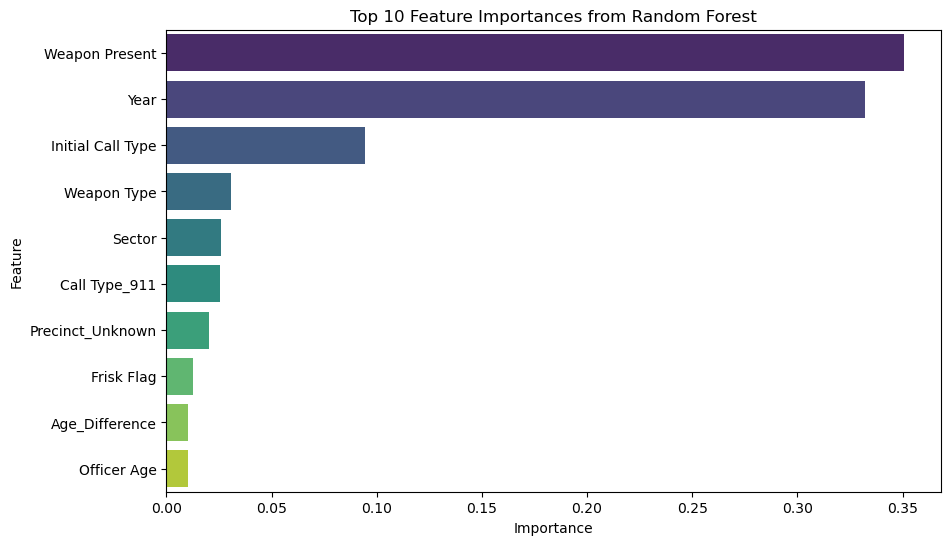

In [118]:
#Visualizing Feature Importances
importances = rf_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 10 Feature Importances from Random Forest')  
plt.show()


In this model `Weapon Present` is the most important feature in determining arrest likelihood. This can be attributed to maybe a policy change and heightened safety concerns over the years hence more arrests.

However, since the Random Forest builds trees independently, there is a need to have a model that actually learns from previous mistakes and errors for better prediction of arrests.

### **4. Gradient Boosting Classifier**

The Gradient Boosting Classifier tends to perform better than Random Forest on tabular data with mixed feature types and imbalanced classes, making it a viable model to evaluate. This is because, unlike Random Forest, gradient boosting learns sequentially from previous mistakes, with each new tree focusing on correcting the errors made by the earlier ones.

In [119]:
from sklearn.ensemble import GradientBoostingClassifier

# Initializing the Model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)

# Fitting the model
gb_model.fit(X_train, y_train)

# Predict
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluating the model
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_gb):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))

ROC-AUC Score: 0.8790

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     11682
           1       0.57      0.03      0.06      1514

    accuracy                           0.89     13196
   macro avg       0.73      0.51      0.50     13196
weighted avg       0.85      0.89      0.84     13196



Gradient Boost Classifier finds all non-arrests with a precision of 89% which coincidentally matches class distribution. However, a 0.03 recall is very bad as it misses 96% of all arrests. This calls for a better model since Recall is very vital for the task at hand.

### **5.ADA Boost**

To address the class imbalance, which AdaBoost does not inherently account for, I used a decision tree as the base estimator and incorporated class weighting.

In [120]:
# Balanced estimator with weights
from sklearn.tree import DecisionTreeClassifier
base_estimator = DecisionTreeClassifier(
    max_depth=1, 
    class_weight='balanced', 
    random_state=42
)

# Initializing AdaBoost
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(
    estimator=base_estimator, # Use our weighted stump
    n_estimators=100,         # Iterate 100 times
    learning_rate=1.0,
    random_state=42
)

# Fitting the model
ada_model.fit(X_train, y_train)

# Predicting using the test data
y_pred_ada = ada_model.predict(X_test)
y_prob_ada = ada_model.predict_proba(X_test)[:, 1]

# Evaluating the model
print(classification_report(y_test, y_pred_ada))
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob_ada)}')

              precision    recall  f1-score   support

           0       1.00      0.56      0.71     11682
           1       0.23      1.00      0.37      1514

    accuracy                           0.61     13196
   macro avg       0.61      0.78      0.54     13196
weighted avg       0.91      0.61      0.68     13196

ROC-AUC: 0.7780773840095874


AdaBoost perfectly captures all arrests (recall = 1.00) at the cost of low precision (0.23) and many false positives, making it highly sensitive but not precise. Situational and evidentiary factors (e.g., weapons, call type) likely drive this extreme recall, as the boosting process aggressively learns to avoid missing high-risk cases.

This model is useful if the goal is not missing any arrest-worthy stops (e.g., for officer safety or accountability), but it would generate excessive alerts in practice.

## **MODEL EVALUATION**

In [121]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score

# Printing out a comparison of all models
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'AdaBoost': ada_model,
    'Dummy Classifier': dummy,
}

results = []
for name, model in models.items():

    # Fitting the models to training data
    model.fit(X_train, y_train)
    
    # Predicting on test data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    F1_score = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': round(accuracy, 4),
        'Recall': round(recall, 4),
        'ROC-AUC': round(roc_auc, 4),
        'F1-Score': round(F1_score, 4)
    })

    # Display results
results_df = pd.DataFrame(results)
print(results_df.sort_values('Recall', ascending=False))

                 Model  Accuracy  Recall  ROC-AUC  F1-Score
3             AdaBoost    0.6071  1.0000   0.7781    0.3687
1        Random Forest    0.7107  0.9373   0.8765    0.4264
0  Logistic Regression    0.6923  0.9300   0.8710    0.4095
2    Gradient Boosting    0.8861  0.0310   0.8790    0.0589
4     Dummy Classifier    0.8853  0.0000   0.5000    0.0000


## *CONCLUSION*

This analysis of Seattle Police Department's Terry stops from 2015–2026 reveals that arrests are predominantly driven by evidentiary and situational factors, such as weapon presence and initial call type, rather than subject demographics like race or age. Among the evaluated models, Random Forest performed best overall (ROC-AUC: 0.8754, balanced recall and precision), while AdaBoost excelled in recall (1.00) but at the cost of many false positives. These findings suggest that SPD's practices are largely evidence-based, but the overrepresentation of certain racial groups in stops (e.g., Black or African American at ~30%) warrants further scrutiny to mitigate potential biases.

For stakeholders like SPD, OPA, and community groups, the models can inform targeted reforms, such as enhanced training on call-type responses or audits in high-arrest sectors. Limitations include the class imbalance impacting precision and the lack of causal inference—future work could incorporate external data (e.g., census demographics) for fairness metrics. Overall, this project underscores the value of data-driven insights in promoting equitable policing and public trust.